# Predicting the Foreign exchange market shocks according governing council date 

In [1]:
!pip install yfinance

  Using cached yfinance-0.2.36-py2.py3-none-any.whl (72 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached frozendict-2.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (116 kB)
  Using cached peewee-3.17.0-cp310-cp310-linux_x86_64.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1


## Modules import :

In [2]:
from datetime import datetime
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import re
import pandas as pd
import yfinance as yf
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
import statsmodels.formula.api as smf


## Introduction 

Communications from central banks, in particular the European Central Bank (ECB), have a significant influence on market expectations and economic trajectories. With this in mind, this study seeks to determine whether the dates of general council meeting, governing council meetings, and press conferences on monetary policies have an impact on the European market, in particular on the STOXX 50, which is a stock market index representing 50 major stocks in the eurozone. This approach combines the temporal information of key events with sentiment analysis derived from press conferences, utilizing the Loughran McDonald dictionary

One of the limitations of this study is that financial markets operate in a highly dynamic environment, reacting not only to central bank communications, but also to a range of external factors. Another notable limitation stems from the rapid return to normality observed after the ECB's press conferences. About an hour after the conclusion of the press conference, futures prices on the market show a complete assimilation of the news. This rapid return to normal underlines a time constraint in the scope of the study, indicating that the immediate impact of the ECB announcements on market expectations may be short-lived. However, we did not have access to Eurostoxx 50 data at a small enough time interval over a sufficiently large sample to model and understand impacts within the same day. To address this, we decided to focus on the daily percentage variation of the STOXX 50.

This study will take into account the dates of ECB meetings and the sentiments delivered during the press conferences, which are webscrapped from ECB website. Then, we will work on the daily percentage variation of the STOXX 50 index, trying to catch the impact of those meetings on this daily variation. Then, the goal is to predict this variation in the future.

To summary this project, firstly, we attempted to highlight the impact of the ECB's governing council, general council, and press conferences on the Eurostoxx. We observed that press conferences had the most significant impact on it. Therefore, we tried to use press conference dates to predict the Eurostoxx in the long and short term. We saw see, that in the long term way, we did not sucess to predict the variation of the STOXX 50 because of the volatility of the market. We saw that daily rolling forecasting could be the solution to fight the volaitly problem. Nevertheless, after modeling, we did not observe a significant improvement in predictions after incorporating press conference dates. A second approach involved incorporating sentiment analysis using the Loughran McDonald dictionary, but unfortunately, this did not yield conclusive results either.

The significance of communication in monetary policy has gained prominence, acknowledging that managing market expectations is equally, if not more, crucial than determining the actual overnight policy rate. Communication stands as a primary avenue through which central bankers can influence market perceptions regarding their future actions. This insight is supported by the event-study analysis conducted by Gürkaynak et al. (2005), demonstrating that on Federal Reserve decision days, the statement exerts an impact on markets beyond the effect of contemporaneous policy rate changes.

Furthermore, our methodological choice is based on the belief that the impacts of ECB announcements may unfold progressively and endure, thus requiring a more extended time frame to fully capture them. Thus, unlike more common approaches likes Carlo Rosa and Giovanni Vergac (2008)  did, that examine intraday variations before, during, and after meetings, our model seeks to explore effects over an extended period.

(https://www.ijcb.org/journal/ijcb08q2a5.pdf)
(https://www.sciencedirect.com/science/article/pii/S0176268022000428?fr=RR-2&ref=pdf_download&rr=84f217cace36f858)

## Scrapping of the dates of the different ECB meetings

In order to determine the impact of ECB Council dates on the financial market, we had to retrieve the date from the ECB website.    
As the url and presentation of the meeting dates were not the same before and after 2016, we had to use two different scrapping methods to work on the two separate web pages.

### Webscrapping for the data before 2016 :

In [2]:
def scrapping_one_year_data(year, press_release):
    
    url="https://www.ecb.europa.eu/press/pr/date/"+str(year)+"/html/" +press_release+".en.html"

    # Get the page content thanks to a HTTP request
    response = requests.get(url)

    # Verify the request is satisfied
    if response.status_code == 200:
        dates = {"Governing Council": [], "General Council": [], "Press conferences": [], "All Dates": []}

        # Analyze the HTML with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Look for <div class="section" lang="en"> or <div class="section"> 
        section_divs = soup.find_all('div', class_='section', lang='en') or soup.find_all('div', class_='section')

        for section_div in section_divs:

            # Look for <h3> or <h2> to find out the meeting type
            meeting_type_list = section_div.find_all(['h3', 'h2']) # All meeting types

            for meeting_type in meeting_type_list: # If they are more than one meeting types

                if meeting_type is not None : # Check if the list is not empty 

                    meeting_type_text = meeting_type.text.strip()

                    meeting_type_key = re.findall(r'Press conferences|Governing Council|General Council', meeting_type_text) # Look for the type of the meeting 
                    key = meeting_type_key[0] if meeting_type_key else "Autre"  # Association with the dictionnary meeting type

                    # Look for the <p> to extract the dates between the <h2> or <h3>
                    next_meeting_type_tag = meeting_type.find_next(['h2','h3'])
                    dates_div = []
                    current_tag = meeting_type.find_next()

                    while current_tag and current_tag != next_meeting_type_tag:
                        if current_tag.name == 'p':
                            dates_div.append(current_tag)
                        current_tag = current_tag.find_next()

                    for date in dates_div:

                        date_match_two_days = re.search(r'(\d+/\d+)\s(\w+\s\d+)', date.text.strip() )

                        if date_match_two_days:
                            jours, mois_annee = date_match_two_days.groups()
                            jours_list = re.split(r'[-/]', jours)

                            # Combinaison des jours avec le mois et l'année pour avoir les jours de conseil distincts
                            dates_list = [f"{jour} {mois_annee}" for jour in jours_list]

                            # Delete city/country names
                            dates_without_city = [re.search(r'\d+\s\w+\s\d+', d).group() if re.search(r'\d+\s\w+\s\d+', d) else None for d in dates_list]

                            # Add dates to the list
                            dates[key].extend(dates_without_city)
                            dates["All Dates"].extend(dates_without_city)

                        else :
                            date_match_without_city = re.search(r'\d+\s\w+\s\d+', date.text.strip()) # Pour enlever les noms des villes/pays
                            date_text = date_match_without_city.group() if date_match_without_city else None
                            
                            if date_text is not None :
                                dates[key].append(date_text)
                                dates["All Dates"].append(date_text)

        return(dates)
    else:
        print(f"Échec de la requête. Code d'état : {response.status_code}")


In [3]:
def create_dataframes(dates, format_date):
    for category, date_list in dates.items():
        dates[category] = [datetime.strptime(date, format_date) for date in date_list]    

    # Create dataframes for all categories
    df_governing_council = pd.DataFrame({"Date": dates["Governing Council"]})
    df_general_council = pd.DataFrame({"Date": dates["General Council"]})
    df_press_conferences = pd.DataFrame({"Date": dates["Press conferences"]})
    df_all_dates = pd.DataFrame({"Date": dates["All Dates"]})

    return df_governing_council, df_general_council, df_press_conferences, df_all_dates


Webscrapping of the webpage : 

In [4]:
press_release=["pr070330","pr090508","pr110420","pr130517"]
years = [2007,2009,2011, 2013] 

year_press_release_pairs = zip(years, press_release)
# Initialize a dictionnary to stock the dataframe of every meeting type
df_governing_council_final = pd.DataFrame()
df_general_council_final = pd.DataFrame()
df_press_conferences_final = pd.DataFrame()
df_all_dates_final = pd.DataFrame()

# Boucler sur les paires (année, press release)
for year, press_release in year_press_release_pairs:
    # Call the webscrapping function
    dates = scrapping_one_year_data(year, press_release)
    # Create the dataframe
    df_governing_council, df_general_council, df_press_conferences, df_all_dates = create_dataframes(dates, '%d %B %Y')

    # Add the dataframe to their proper type in the dictionnary
    df_governing_council_final = pd.concat([df_governing_council_final, df_governing_council], axis=0, ignore_index=True)
    df_general_council_final = pd.concat([df_general_council_final, df_general_council], axis=0, ignore_index=True)
    df_press_conferences_final = pd.concat([df_press_conferences_final, df_press_conferences], axis=0, ignore_index=True)
    df_all_dates_final = pd.concat([df_all_dates_final, df_all_dates], axis=0, ignore_index=True)


### Webscrapping for the data after 2016 :

In [5]:
def scrapping_one_page_from_archive(date):

    url = f"https://web.archive.org/web/{date}/https://www.ecb.europa.eu/press/calendars/mgcgc/html/index.en.html"

    response = requests.get(url)

    if response.status_code == 200:

        dates = {"Governing Council": [], "General Council": [], "Press conference": [], "All Dates": []}

        # Analyser le contenu HTML avec BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Look for <div class="definition-list -zebra">
        section_divs = soup.find_all('dl', class_='pubList') or soup.find_all('div', class_='definition-list -zebra')
        
        for section_div in section_divs:
            # Look for <dd> to find out the meeting type
            meeting_type_list = section_div.find_all('dd')

            for meeting_type in meeting_type_list : 
                meeting_type_text = meeting_type.text.strip()

                # Extraction du premier type de réunion s'il y en a deux sur la même ligne
                meeting_type_key = re.findall(r'Press conference|Governing Council|General Council', meeting_type_text)
                key = meeting_type_key[0] if meeting_type_key else "Autre"

                dates_div = []

                dates_div.append(meeting_type.find_previous('dt'))
                
                for date in dates_div:
                        
                    date_match_day = re.search(r'(\d+/\d+/\d+)', date.text.strip())

                    if date_match_day:
                        date_text = date_match_day.group() if date_match_day else None

                        dates[key].append(date_text)
                        dates["All Dates"].append(date_text)
        dates["Press conferences"] = dates.pop("Press conference")
        return dates

    else:
        print(f"Échec de la requête. Code d'état : {response.status_code}")

In [6]:
dates = [20151220151041, 20170126223123, 20180128032305, 20190127223531, 20200311084017, 20210309130411, 20220103104133, 20230121220001]

for date in dates : 
    dates = scrapping_one_page_from_archive(date) 
    df_governing_council, df_general_council, df_press_conferences, df_all_dates = create_dataframes(dates, '%d/%m/%Y')

    df_governing_council_final = pd.concat([df_governing_council_final, df_governing_council], axis=0, ignore_index=True)
    df_general_council_final = pd.concat([df_general_council_final, df_general_council], axis=0, ignore_index=True)
    df_press_conferences_final = pd.concat([df_press_conferences_final, df_press_conferences], axis=0, ignore_index=True)
    df_all_dates_final = pd.concat([df_all_dates_final, df_all_dates], axis=0, ignore_index=True)


In [7]:
df_governing_council_final.drop_duplicates(inplace=True)
df_general_council_final.drop_duplicates(inplace=True)
df_press_conferences_final.drop_duplicates(inplace=True)
df_all_dates_final.drop_duplicates(inplace=True)

## STOXX 50 data

To collect the stoxx 50 index, we use the yfinance library which can give us the index for a given time interval. To counteract the swift return to normal, we have decided to calculate the daily percentage variation of the Stoxx 50. The formula, titled `High - Low / Low`, serves as an indicator of variation or percentage change between the highest price (`High`) and the lowest price (`Low`) of an asset during a given period.


In [92]:
def get_stoxx50_data(start_date, end_date):
    # Symbole du Stoxx 50 sur Yahoo Finance
    symbol = "^STOXX50E"
    
    # Récupérer les données
    data = yf.download(symbol, start=start_date, end=end_date)
    data=data[["Open","Adj Close","Close","High","Low"]].copy()
    df=pd.DataFrame(data)
    df.rename(columns={"Open":"open_index","Adj Close":"stox_index","Close":"close_index", "High":"high_index", "Low":"low_index"},inplace=True)

    df.reset_index(inplace=True)

    df["daily_pct_variation"] = ((df["high_index"] - df["low_index"]) / df["low_index"]) *100

    df["daily_return"] = df["stox_index"].pct_change() * 100
    df.dropna(inplace=True)

    return df

In [93]:
# Période de temps souhaitée (par exemple, du 1er janvier 2022 au 1er janvier 2023)
start_date = "2009-01-01"
end_date = "2023-01-01"

# Récupérer les données du Stoxx 50
stoxx50_data = get_stoxx50_data(start_date, end_date)


stoxx50_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,open_index,stox_index,close_index,high_index,low_index,daily_pct_variation,daily_return
1,2009-01-06,2558.340088,2578.429932,2578.429932,2608.149902,2542.689941,2.574437,0.979867
2,2009-01-07,2570.870117,2538.550049,2538.550049,2572.070068,2520.610107,2.041568,-1.546673
3,2009-01-08,2516.860107,2516.560059,2516.560059,2532.050049,2481.669922,2.030090,-0.866242
4,2009-01-09,2524.739990,2486.590088,2486.590088,2543.830078,2466.139893,3.150275,-1.190910
5,2009-01-12,2482.790039,2451.870117,2451.870117,2491.090088,2447.590088,1.777258,-1.396288


In [94]:
stoxx50_data["Is_Governing_Council_Date"] = stoxx50_data["Date"].isin(df_governing_council_final['Date']).astype(int)
stoxx50_data["Is_General_Council_Date"] = stoxx50_data["Date"].isin(df_general_council_final['Date']).astype(int)
stoxx50_data["Is_Press_conference_Date"] = stoxx50_data["Date"].isin(df_press_conferences_final['Date']).astype(int)
stoxx50_data["Is_Governing_Council_Date"] = stoxx50_data["Date"].isin(df_all_dates_final['Date']).astype(int)  # POURQUOI ?

# Descriptive Statistics to Measure the Impact of ECB Announcements on the STOXX 50


### Impact des dates des governing council

**Histogram according to the day with/without meeting :**

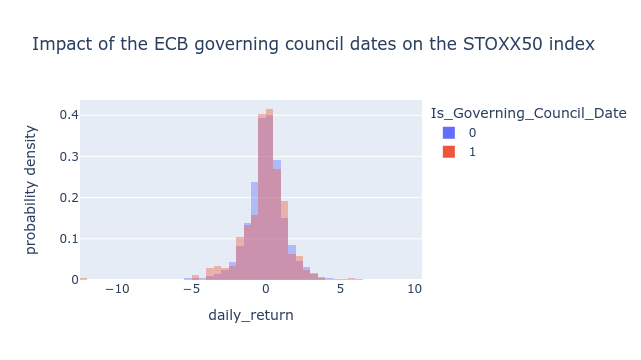

In [18]:
px.histogram(stoxx50_data,x="daily_return", nbins = 50, color="Is_Governing_Council_Date",barmode="overlay", opacity=0.4, histnorm= "probability density", title="Impact of the ECB governing council dates on the STOXX50 index")

**Descriptive statistics :**

In [20]:
stoxx50_data.groupby('Is_Governing_Council_Date')["daily_return"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_Governing_Council_Date,,,,,,,,
0,3170.0,0.028213,1.346798,-8.616921,-0.626140,0.044921,0.690476,10.347654
1,342.0,-0.049973,1.515834,-12.401398,-0.613997,0.062908,0.651427,5.669414


**Daily representation :**

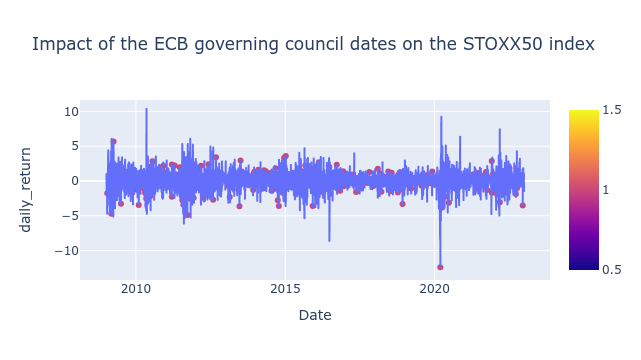

In [21]:
fig = px.line(stoxx50_data, x="Date", y="daily_return", title="Impact of the ECB governing council dates on the STOXX50 index")
# ou stox_index en y
scatter_data = stoxx50_data[stoxx50_data['Is_Governing_Council_Date'] == 1]
fig.add_trace(px.scatter(scatter_data, x="Date", y="daily_return", color='Is_Governing_Council_Date').data[0])

fig.show()

### Impact des dates des general council

**Histogram according to the day with/without meeting :**

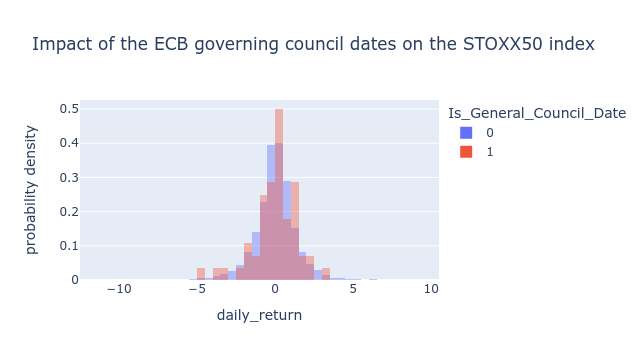

In [22]:
px.histogram(stoxx50_data,x="daily_return", nbins = 50, color="Is_General_Council_Date",barmode="overlay", opacity=0.4, histnorm= "probability density", title="Impact of the ECB governing council dates on the STOXX50 index")

**Descriptive statistics :**

In [23]:
stoxx50_data.groupby('Is_General_Council_Date')["daily_return"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_General_Council_Date,,,,,,,,
0,3456.0,0.020973,1.363046,-12.401398,-0.626485,0.044921,0.684452,10.347654
1,56.0,-0.002440,1.442860,-4.895901,-0.604261,0.120581,0.924661,3.334874


**Daily representation :**

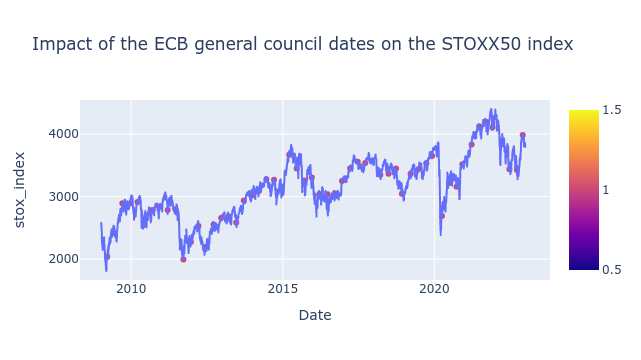

In [17]:
fig = px.line(stoxx50_data, x="Date", y="stox_index", title="Impact of the ECB general council dates on the STOXX50 index")

scatter_data = stoxx50_data[stoxx50_data['Is_General_Council_Date'] == 1]
fig.add_trace(px.scatter(scatter_data, x="Date", y="stox_index", color='Is_General_Council_Date').data[0])

fig.show()

### Impact des dates des press conferences

The ECB Governing Council's press conference, held forty-five minutes after the announcement of its monetary policy decision in the form of a press release, is an important method of communication. This press conference is closely followed by market participants and can significantly influence their overall economic assessment.

*ref :* https://doi.org/10.1016/j.ejpoleco.2022.102230

**Histogram according to the day with/without meeting :**

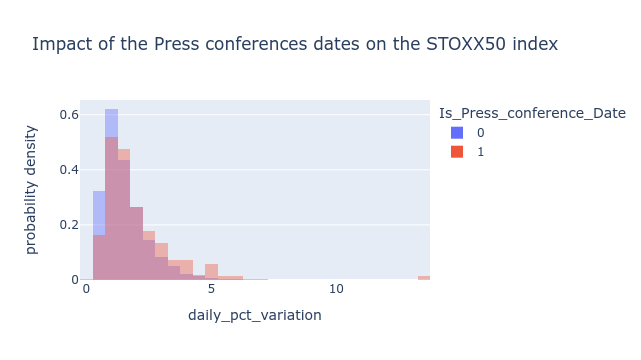

In [25]:
px.histogram(stoxx50_data,x="daily_pct_variation", nbins = 50, color="Is_Press_conference_Date",barmode="overlay", opacity=0.4, histnorm= "probability density", title="Impact of the Press conferences dates on the STOXX50 index")

**Descriptive statistics :**

In [26]:
stoxx50_data.groupby('Is_Press_conference_Date')["daily_pct_variation"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_Press_conference_Date,,,,,,,,
0,3377.0,1.550472,1.011041,0.000000,0.876678,1.305757,1.925158,11.067632
1,135.0,2.008635,1.537603,0.477384,1.127084,1.593075,2.380841,13.697760


**Daily representation :**

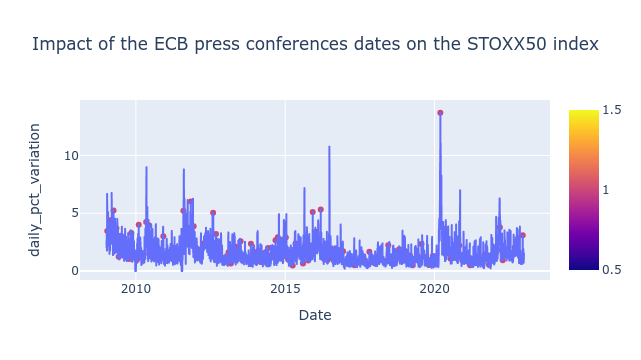

In [36]:
fig = px.line(stoxx50_data, x="Date", y="daily_pct_variation", title="Impact of the ECB press conferences dates on the STOXX50 index")

scatter_data = stoxx50_data[stoxx50_data['Is_Press_conference_Date'] == 1]
fig.add_trace(px.scatter(scatter_data, x="Date", y="daily_pct_variation", color='Is_Press_conference_Date').data[0])

fig.show()

At first glance, it appears that press conferences have the most significant impact on the STOXX 50. In a second step, we measure the impact through regression to validate this hypothesis.

**Measure of the impact with a regression :**

In [32]:
mod = smf.ols(formula='daily_pct_variation ~ Is_Press_conference_Date', data=stoxx50_data)

res = mod.fit()

print(res.summary())


                             OLS Regression Results                            
Dep. Variable:     daily_pct_variation   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     25.38
Date:                 Wed, 10 Jan 2024   Prob (F-statistic):           4.93e-07
Time:                         21:22:51   Log-Likelihood:                -5106.8
No. Observations:                 3512   AIC:                         1.022e+04
Df Residuals:                     3510   BIC:                         1.023e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

<!-- Impact des dates des Press Conferences   -->

The press conference dates seems to be the only one that can have an impact on the stox index, as other dates coefficients(governing and general council) are not significant at 5% in the regression of the stox index on the dates. Nevertheless, the coefficient find for the press conference is relatively low.

## Checking of the stationnarity of the data

As we have seen in the precedent plots, the serie is likely to have a temporal increasing trend. In order to forecast this serie, we have to stationnarize it by differenciating the serie.

### Checking the regression coeff

In [45]:
mod = smf.ols(formula='daily_pct_variation ~ stoxx50_data.index', data=stoxx50_data)

res = mod.fit()

print(res.summary())


                             OLS Regression Results                            
Dep. Variable:     daily_pct_variation   R-squared:                       0.033
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     118.1
Date:                 Wed, 10 Jan 2024   Prob (F-statistic):           4.50e-27
Time:                         21:41:02   Log-Likelihood:                -5059.9
No. Observations:                 3511   AIC:                         1.012e+04
Df Residuals:                     3509   BIC:                         1.014e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.8

### ADF test

In [51]:
# on différencie l'index à prédire (fonctionne aussi avec le daily_return): 
stoxx50_data["daily_pct_variation_diff"] = stoxx50_data["daily_pct_variation"].diff()

stoxx50_data.dropna(inplace=True)

stoxx50_data.head()

,Date,open_index,stox_index,close_index,high_index,low_index,daily_pct_variation,daily_return,Is_Governing_Council_Date,Is_General_Council_Date,Is_Press_conference_Date,daily_pct_variation_diff,daily_pct_variation_diff_diff
5,2009-01-12,2482.790039,2451.870117,2451.870117,2491.090088,2447.590088,1.777258,-1.396288,0,0,0,-1.373016,-2.493202
6,2009-01-13,2445.040039,2411.280029,2411.280029,2445.040039,2385.040039,2.515681,-1.655475,0,0,0,0.738423,2.111439
7,2009-01-14,2420.429932,2298.459961,2298.459961,2426.290039,2274.620117,6.667923,-4.678846,0,0,0,4.152242,3.413819
8,2009-01-15,2300.830078,2257.669922,2257.669922,2312.830078,2235.300049,3.468439,-1.774668,1,0,1,-3.199484,-7.351726
9,2009-01-16,2281.790039,2281.449951,2281.449951,2343.110107,2278.199951,2.849186,1.053300,0,0,0,-0.619253,2.580230


We verify that the serie is now detrend with a unit root test (ADF test) : 

In [52]:
# Assuming df is your DataFrame with a column "Index_Value"
result_adf = adfuller(stoxx50_data['daily_pct_variation'], regression="ct")
print('ADF Statistic before differenciation:', result_adf[0])
print('p-value:', result_adf[1])
print("----------------------------------------------------")
result_adf_with_diff = adfuller(stoxx50_data['daily_pct_variation_diff'], regression="ct")
print('ADF Statistic after differenciation:', result_adf_with_diff[0])
print('p-value:', result_adf_with_diff[1])
print("----------------------------------------------------")
result_adf_with_daily_return = adfuller(stoxx50_data['daily_return'], regression="ct")
print('ADF Statistic with daily return:', result_adf_with_daily_return[0])
print('p-value:', result_adf_with_daily_return[1])

ADF Statistic before differenciation: -9.42696841822318
p-value: 4.025523943570705e-14
----------------------------------------------------
ADF Statistic after differenciation: -15.50536106790099
p-value: 1.387036599010546e-22
----------------------------------------------------
ADF Statistic with daily return: -60.17242093611099
p-value: 0.0


Visualisation of the time serie :

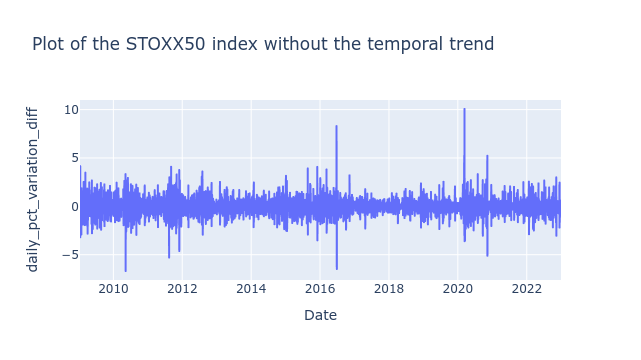

In [53]:
fig = px.line(stoxx50_data, x="Date", y="daily_pct_variation_diff", title="Plot of the STOXX50 index without the temporal trend")
fig.show()

### Construction of the BDD train/test

The initial approach is to consider all the years between 2008 and 2021 to predict the year 2022. However, caution is warranted as this may introduce bias by incorporating lingering effects from previous years.

In [54]:
stoxx50_data_train = stoxx50_data.loc[stoxx50_data["Date"]<="2021-12-31"].copy()
stoxx50_data_test = stoxx50_data.loc[stoxx50_data["Date"]>"2021-12-31"].copy() # 1 year of test data

## Beginning of the modelisation with Time Serie modeling :

**LITERATURE :**
  - "Analysis of ARIMA-Artificial Neural Network Hybrid Model in Forecasting of Stock Market Returns", 10.9734/ajpas/2020/v6i230157

### ACF and PACF plots to find p and q :

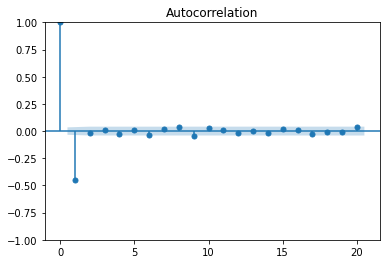

In [55]:
plot_acf(stoxx50_data_train["daily_pct_variation_diff"],lags=20)
plt.show()

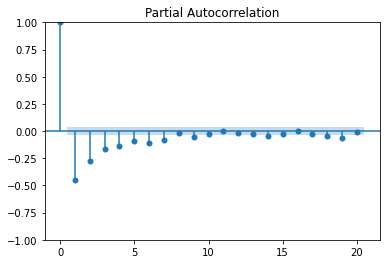

In [62]:
plot_pacf(stoxx50_data_train["daily_pct_variation_diff"],lags=20)
plt.show()

### Make grid search to fit the (p,d,q) parametres with auto_arima functions

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=8731.161, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=7519.210, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=8009.170, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=7507.152, Time=0.72 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=7756.807, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=7502.988, Time=0.88 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=7668.054, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=7491.276, Time=1.20 sec
 ARIMA(4,1,0)(0,0,0)[1] intercept   : AIC=7608.570, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[1] intercept   : AIC=7482.637, Time=2.60 sec
 ARIMA(5,1,0)(0,0,0)[1] intercept   : AIC=7582.025, Time=0.53 sec

Best model:  ARIMA(4,1,1)(0,0,0)[1] intercept
Total fit time: 8.489 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3254
Model:               SARIMAX(4, 1, 1)  

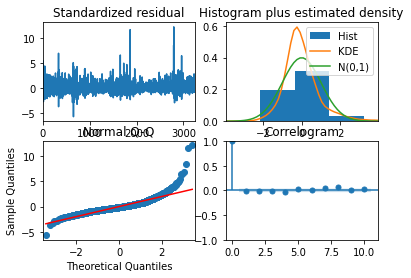

In [64]:
from pmdarima import auto_arima
model = auto_arima(
    stoxx50_data_train["daily_pct_variation"],
    test="kpss",
    start_p = 0, start_q = 0, 
    max_p=6,max_q=1,
	# exogenous=stoxx50_data_train["Is_Press_conference_Date"],
    stepwise = False, # to test all combinations
	trace=True,
	error_action="ignore",
	suppress_warnings=True,
	)
print(model.summary())
model.plot_diagnostics()
plt.show()

Model chosen according to the auto arima procedure :

In [66]:
arima_model = ARIMA(endog= stoxx50_data_train["daily_pct_variation"],
                            # exog = stoxx50_data_train["Is_Press_conference_Date"],
                            order=(4,1,1))
model_fit = arima_model.fit()
forecast = model_fit.get_forecast(steps=len(stoxx50_data_test),
                                #   exog=stoxx50_data_test["Is_Press_conference_Date"], 
                                  alpha = 0.05)
predicted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [69]:
stoxx50_data_test["predicted_values"] = predicted_values.values
stoxx50_data_test["predicted_values_upper"] = conf_int["upper daily_pct_variation"].values
stoxx50_data_test["predicted_values_lower"] = conf_int["lower daily_pct_variation"].values

In [70]:
# Evaluate the model
mse = mean_squared_error(stoxx50_data_test["daily_pct_variation"], stoxx50_data_test["predicted_values"])
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

mse = mean_squared_error(stoxx50_data_test["daily_pct_variation"], stoxx50_data_test["predicted_values"])
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 1.1591572688654914


### Rolling forecasting procedure :

We can observe that attempting to predict the Eurostoxx50 over the long term does not seem relevant, whether considering the dates or not. Therefore, as a second step, we aim to shift our focus to rolling forecasting procedure.

We generate a prediction for each element on the test set.  
A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, we re-create the ARIMA model after each new observation is received.  
we manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended at each iteration.

*ref :* https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70   
https://neptune.ai/blog/arima-vs-prophet-vs-lstm



**Warning** : the algorithm takes a long time to run (15 minutes), so we recommend you to do not run it and just look at the result.

In [79]:
############ ROLLING ARIMA MODEL ################

history = list(stoxx50_data_train["daily_pct_variation"].values)
exog_value = list(stoxx50_data_train["Is_Press_conference_Date"].values)
test_data = list(stoxx50_data_test["daily_pct_variation"].values)
exog_test_value = list(stoxx50_data_test["Is_Press_conference_Date"].values)
predicted_values = []
upper_conf = []
lower_conf = []

for time_point in range(len(stoxx50_data_test)):
    model = ARIMA(endog= history,
                         exog = exog_value,
                          order=(4,1,1))
    
    model_fit = model.fit()
    output = model_fit.get_forecast(step = 1,
                                exog = exog_test_value[time_point] 
                                )
    
    output_predicted_values = output.predicted_mean[0]
    conf_int = output.conf_int()[0]
    predicted_values.append(output_predicted_values)
    lower_conf.append(conf_int[0])
    upper_conf.append(conf_int[1])

    true_test_value = test_data[time_point]

    exog_value.append(exog_test_value[time_point])
    history.append(true_test_value)

# Add the predicted values to the test dataset 
stoxx50_data_test["predicted_values"] = predicted_values
stoxx50_data_test["predicted_values_upper"] = upper_conf
stoxx50_data_test["predicted_values_lower"] = lower_conf

In [80]:
# Evaluate the model
mse = mean_squared_error(stoxx50_data_test["daily_pct_variation"], stoxx50_data_test["predicted_values"])
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 0.7702541360415629


### Plot of predicted values :

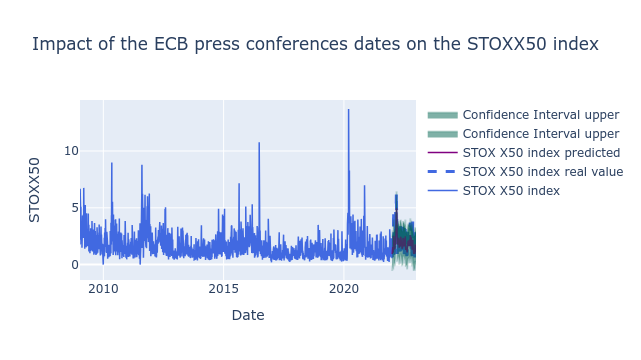

In [81]:

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=stoxx50_data_train["Date"], y=stoxx50_data_train["daily_pct_variation"], name='STOX X50 index',
                         line=dict(color='royalblue', width=1.5)))

fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["daily_pct_variation"], name='STOX X50 index real value',
                         line=dict(color='royalblue', width=3, dash = "dash")))


fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["predicted_values"], name='STOX X50 index predicted',
                         line=dict(color='purple', width=1.5)))

# Confidence interval 

fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["predicted_values_upper"], 
    line=dict(color='rgba(0,100,80,0.2)'),
    fill='tonexty',
    name='Confidence Interval upper'
))

fig.add_trace(go.Scatter(x=stoxx50_data_test["Date"], y=stoxx50_data_test["predicted_values_lower"],  
    line=dict(color='rgba(0,100,80,0.2)'),
    fill='tonexty',
    name='Confidence Interval upper' 
))

# Edit the layout
fig.update_layout(title='Impact of the ECB press conferences dates on the STOXX50 index',
                   xaxis_title='Date',
                   yaxis_title='STOXX50')



Predicting day by day appears to be the most effective way to model Eurostoxx variations. However, it should be noted that the impact identified through this modeling does not seem to be relatively high. This corroborates the results that we observed in the descriptive statistics.

## NLP

In a second phase, we aim to incorporate the sentiment conveyed during the press conference to assess the impact of monetary decisions on the financial market and determine whether this can enhance the predictions made previously. To achieve this, we utilize the lexicon provided by Loughran and McDonald (2011) 

In [8]:
dates_press_conferences = list(df_press_conferences_final.Date.astype("str"))


In [9]:

url= 'https://www.ecb.europa.eu/press/pr/date/html/index.en.html'

# Get the page content thanks to a HTTP request
response = requests.get(url)

# Verify the request is satisfied
if response.status_code == 200:
    
    # Analyze the HTML with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    section_div = soup.find('div', class_= 'definition-list -filter')

    lazyload_container = section_div.find('dl', id= "lazyload-container" )

    snippets_urls = lazyload_container['data-snippets'].split(',')

    for snippet_url in snippets_urls:
        full_url = "https://www.ecb.europa.eu/press/pr/date/" +  snippet_url[3:]
        
        snippet_response = requests.get(full_url)

        if snippet_response.status_code == 200:
            # Parsez le contenu et ajoutez-le à votre document
            snippet_soup = BeautifulSoup(snippet_response.content, 'html.parser')
            lazyload_container.append(snippet_soup)
        


In [44]:

date_tags = lazyload_container.find_all('dt', {'isodate': dates_press_conferences})
target_category = "MONETARY POLICY DECISION"
# Liste des liens à visiter
links_to_visit = []
monetary_policy_decision_dates = []

for date_tag in date_tags:
    # Find the associated dd tag
    dd_tag = date_tag.find_next('dd')
    
    # Find the divs with the target category and title within the dd tag
    category_div = dd_tag.find('div', class_='category')
    title_div = dd_tag.find('div', class_='title')

    if category_div and title_div:
        if category_div.get_text() == target_category:
            # Find the link within the title_div
            link = title_div.find('a')
            if link is not None:
                href_value = link.get('href')
                href_ecb = "https://www.ecb.europa.eu"+href_value
                links_to_visit.append(href_ecb)
                monetary_policy_decision_dates.append(date_tag)





In [33]:
def scrapping_load_text(url):
    stop_text="The President of the ECB will comment" # Get the page content thanks to a HTTP request
    response = requests.get(url)

    # Verify the request is satisfied
    if response.status_code == 200:
        # Analyze the HTML with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p', class_=lambda x: x != 'ecb-publicationDate')
    
    # create concatenated storage
        concatenated_text = ""

        # Loop through paragraphs
        for paragraph in paragraphs:
            # Check if the text contains "disclaimer"
            if stop_text.lower() in paragraph.text.lower():                
                break  # Stop scraping when disclaimer is found

            # Check if the text contains '*', and skip the paragraph if it does
            if '*' in paragraph.text:
                continue

            # Concatenate text
            concatenated_text += paragraph.text

        return concatenated_text

In [84]:

df_statements = pd.DataFrame(columns=["Date", "text"])

for jour,link in enumerate(links_to_visit):
    text = scrapping_load_text(link)
    date = monetary_policy_decision_dates[jour]["isodate"]

    df_statements = df_statements.append({"Date": date, "text": text}, ignore_index=True)

df_statements["Date"] = pd.to_datetime(df_statements["Date"])
df_statements = df_statements.set_index("Date")

C:\Users\elelo\AppData\Local\Temp/ipykernel_16156/3945652925.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_statements = df_statements.append({"Date": date, "text": text}, ignore_index=True)
C:\Users\elelo\AppData\Local\Temp/ipykernel_16156/3945652925.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_statements = df_statements.append({"Date": date, "text": text}, ignore_index=True)
C:\Users\elelo\AppData\Local\Temp/ipykernel_16156/3945652925.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_statements = df_statements.append({"Date": date, "text": text}, ignore_index=True)
C:\Users\elelo\AppData\Local\Temp/ipykernel_16156/3945652925.py:7: FutureWarning: The frame.append method is deprecated and will be remo

In [67]:
lm = pd.read_csv("Loughran-McDonald_MasterDictionary_1993-2021.csv") 

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}


def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts = pd.concat({k: get_total_count(df_statements["text"], lm, v) for k, v in funcs.items()}, axis=1)

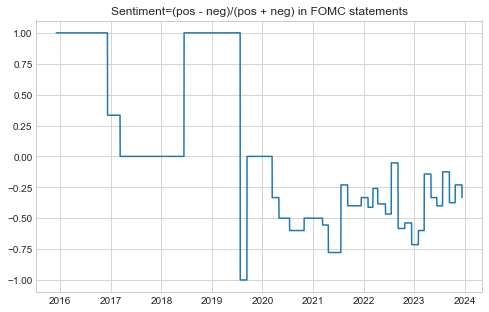

In [96]:
from skfin.plot import * 
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in FOMC statements",
)

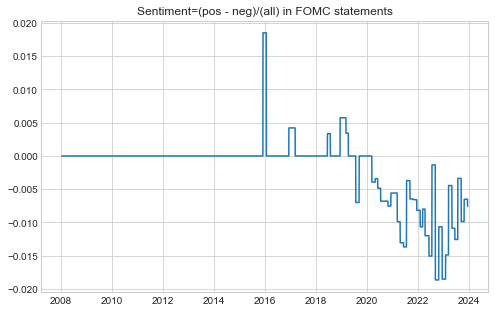

In [89]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(all) in FOMC statements",
)

As we seen in the course, in the first case, short documents (with few or no sentiment words) might lead to biased estimates. So we decided to take the second approach in our project

## Sentiment in MONETARY POLICY DECISION statements: supervised learning

In [90]:
import numpy as np
from pandas.tseries.offsets import BDay
from skfin.datasets import load_kf_returns
from skfin.text import show_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline

In [137]:
df = stoxx50_data[['Date','daily_pct_variation']]

df = pd.merge(df,
         df_statements.reset_index().drop_duplicates(),
         on = "Date",
         how = "left")

In [138]:
df

,Date,daily_pct_variation,text
0,2009-01-06,2.574437,NaN
1,2009-01-07,2.041568,NaN
2,2009-01-08,2.030090,NaN
3,2009-01-09,3.150275,NaN
4,2009-01-12,1.777258,NaN
...,...,...,...
3509,2022-12-23,0.917939,NaN
3510,2022-12-27,0.721719,NaN
3511,2022-12-28,0.953248,NaN
3512,2022-12-29,1.532720,NaN


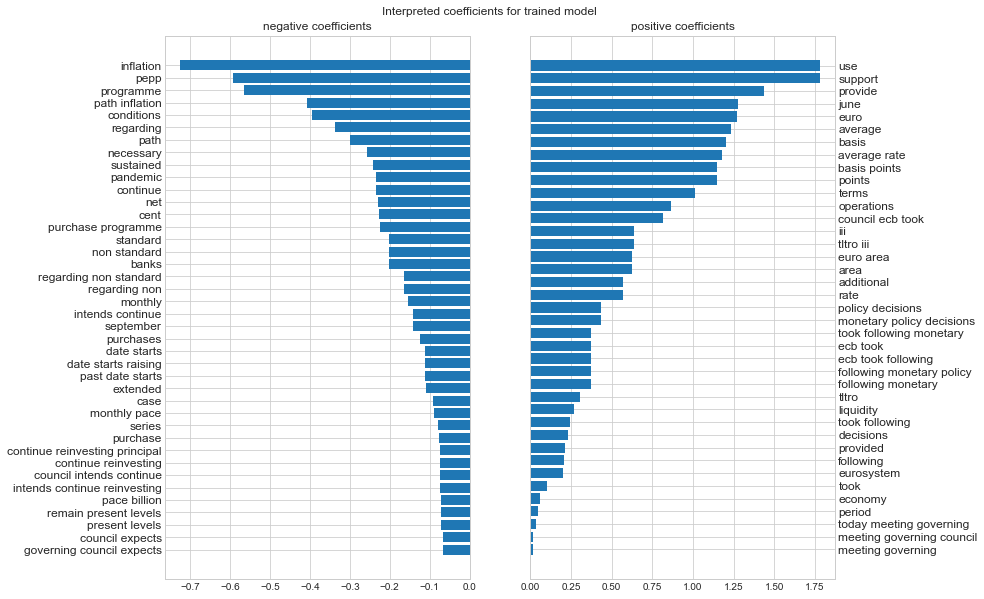

In [141]:
from skfin.text import *

est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0075)),
    ]
)

df_est = df.dropna()
y = df_est["daily_pct_variation"].dropna()
X = df_est["text"]
est.fit(X, y)
vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
coefs_plot(interpret_coef, title="Interpreted coefficients for trained model")

In summarizing this project, our initial focus was on assessing the impact of the European Central Bank's (ECB) governing council, general council, and press conferences on the Eurostoxx. Notably, we found that press conferences exerted the most substantial influence. Subsequently, our attempt to utilize press conference dates for both long and short-term predictions faced challenges, particularly in the long term due to market volatility.

Recognizing the volatility issue, we explored daily rolling forecasting as a potential solution. However, despite our efforts, incorporating press conference dates did not yield a significant improvement in predicting STOXX 50 variations. A secondary approach involved integrating sentiment analysis using the Loughran McDonald dictionary. Regrettably, this alternative did not provide conclusive results either. In the sense that the collected information did not lead to a significant improvement in the obtained predictions (0.1 in the RMSE)

In essence, our endeavors highlighted the complexity of predicting market behavior, especially in the context of ECB-related events. While our analyses and methodologies addressed various aspects, achieving significant predictive accuracy remains a formidable challenge in the dynamic landscape of financial markets.

Furthermore, according to Conor Parle (2022), "Moreover, the observed effect on stock markets was stronger prior to the introduction of formal forward guidance in 2013 by
the ECB, suggesting market impacts have been more subdued since the ECB has implemented a more forward looking strategy to
communicate information about the present state of the economy and likely future course of monetary policy. This suggests that
since this more explicit steering of expectations, central bank private information revealed in the monetary policy press conference
is less of a surprise to financial market participants. 
". This observation may explain why the dates of press conferences do not appear to significantly impact the Eurostoxx50.

https://www.sciencedirect.com/science/article/pii/S0176268022000428?fr=RR-2&ref=pdf_download&rr=84f217cace36f858

